In [2]:
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
names = open('names.txt','r').read().splitlines()
chars = sorted(list(set((''.join(names)))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

In [4]:
def train_dev_test_data(names, block_size=3, n=None):
    X, y = [], []
    for name in names[:n]:
        context = [0] * block_size
        for char in name + '.':
            i = stoi[char]
            X.append(context)
            y.append(i)
            if n is not None and n < 10:
                print(''.join(itos[j] for j in context), '->', itos[i])
            context = context[1:] + [i]
    
    zipped = list(zip(X, y))
    random.shuffle(zipped)
    X, y = zip(*zipped)
    
    n_dev = int(0.8 * len(X))
    n_test = int(0.9 * len(X))
    
    X_train = torch.tensor(X[:n_dev])
    y_train = torch.tensor(y[:n_dev])
    
    X_dev = torch.tensor(X[n_dev:n_test])
    y_dev = torch.tensor(y[n_dev:n_test])
    
    X_test = torch.tensor(X[n_test:])
    y_test = torch.tensor(y[n_test:])
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [5]:
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, n=2, block_size=3)

... -> e
..e -> m
.em -> m
emm -> a
mma -> .
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .


In [21]:
X_train.shape, X_train.dtype, y_train.shape, y_train.dtype

(torch.Size([9, 3]), torch.int64, torch.Size([9]), torch.int64)

In [22]:
X_dev.shape, X_dev.dtype, y_dev.shape, y_dev.dtype

(torch.Size([1, 3]), torch.int64, torch.Size([1]), torch.int64)

In [23]:
X_test.shape, X_test.dtype, y_test.shape, y_test.dtype

(torch.Size([2, 3]), torch.int64, torch.Size([2]), torch.int64)

In [24]:
# embed 27 possible output chars (rows) into 2 dimensional vector space (cols)
C = torch.randn(27, 2)
print(C)

tensor([[-0.7790, -1.0044],
        [-0.0338,  0.2858],
        [ 0.4344,  1.1650],
        [-1.2435,  0.4437],
        [ 1.6425,  0.3176],
        [-1.0353, -1.1754],
        [ 0.3561, -0.9735],
        [ 0.1633, -0.8352],
        [ 0.8442,  0.7030],
        [-0.3424,  1.7924],
        [ 0.3038,  0.0190],
        [-0.3059, -0.3271],
        [ 2.0937, -0.5044],
        [ 0.4086, -0.1187],
        [-0.4709, -0.1303],
        [ 1.9620,  0.2919],
        [ 1.4112, -0.3573],
        [ 0.3229, -0.5892],
        [ 0.5256, -0.6232],
        [ 0.5495, -1.3806],
        [ 1.1203, -0.5219],
        [ 0.8373,  1.6658],
        [ 1.3685,  0.0788],
        [-0.2839,  1.9553],
        [ 0.1993,  0.3543],
        [ 3.4678,  0.1800],
        [-0.0328,  0.8323]])


**Indexing instead of one-hot encoding**

We could retrieve the embedding of each input by one hot encoding it and then doing `X_onehot @ C`, but it's equivalent to just indexing which is must faster, i.e. `X_onehot = F.one_hot(X); X_onehot @ C == C[X]`.

In [25]:
emb = C[X_train]
print(emb.shape)
print(emb)
emb.view(-1)

torch.Size([9, 3, 2])
tensor([[[-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [-1.0353, -1.1754]],

        [[ 0.4086, -0.1187],
         [ 0.4086, -0.1187],
         [-0.0338,  0.2858]],

        [[-0.7790, -1.0044],
         [-1.0353, -1.1754],
         [ 0.4086, -0.1187]],

        [[ 1.3685,  0.0788],
         [-0.3424,  1.7924],
         [-0.0338,  0.2858]],

        [[ 2.0937, -0.5044],
         [-0.3424,  1.7924],
         [ 1.3685,  0.0788]],

        [[-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [ 1.9620,  0.2919]],

        [[-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [-0.7790, -1.0044]],

        [[ 1.9620,  0.2919],
         [ 2.0937, -0.5044],
         [-0.3424,  1.7924]],

        [[-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [-0.7790, -1.0044]]])


tensor([-0.7790, -1.0044, -0.7790, -1.0044, -1.0353, -1.1754,  0.4086, -0.1187,
         0.4086, -0.1187, -0.0338,  0.2858, -0.7790, -1.0044, -1.0353, -1.1754,
         0.4086, -0.1187,  1.3685,  0.0788, -0.3424,  1.7924, -0.0338,  0.2858,
         2.0937, -0.5044, -0.3424,  1.7924,  1.3685,  0.0788, -0.7790, -1.0044,
        -0.7790, -1.0044,  1.9620,  0.2919, -0.7790, -1.0044, -0.7790, -1.0044,
        -0.7790, -1.0044,  1.9620,  0.2919,  2.0937, -0.5044, -0.3424,  1.7924,
        -0.7790, -1.0044, -0.7790, -1.0044, -0.7790, -1.0044])

In [26]:
n_hid = 100

W1 = torch.randn(6, n_hid)
b1 = torch.randn(n_hid)

In [27]:
input_ = torch.cat(torch.unbind(emb, 1), 1)
print(input_)
torch.unbind(emb, 1)

tensor([[-0.7790, -1.0044, -0.7790, -1.0044, -1.0353, -1.1754],
        [ 0.4086, -0.1187,  0.4086, -0.1187, -0.0338,  0.2858],
        [-0.7790, -1.0044, -1.0353, -1.1754,  0.4086, -0.1187],
        [ 1.3685,  0.0788, -0.3424,  1.7924, -0.0338,  0.2858],
        [ 2.0937, -0.5044, -0.3424,  1.7924,  1.3685,  0.0788],
        [-0.7790, -1.0044, -0.7790, -1.0044,  1.9620,  0.2919],
        [-0.7790, -1.0044, -0.7790, -1.0044, -0.7790, -1.0044],
        [ 1.9620,  0.2919,  2.0937, -0.5044, -0.3424,  1.7924],
        [-0.7790, -1.0044, -0.7790, -1.0044, -0.7790, -1.0044]])


(tensor([[-0.7790, -1.0044],
         [ 0.4086, -0.1187],
         [-0.7790, -1.0044],
         [ 1.3685,  0.0788],
         [ 2.0937, -0.5044],
         [-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [ 1.9620,  0.2919],
         [-0.7790, -1.0044]]),
 tensor([[-0.7790, -1.0044],
         [ 0.4086, -0.1187],
         [-1.0353, -1.1754],
         [-0.3424,  1.7924],
         [-0.3424,  1.7924],
         [-0.7790, -1.0044],
         [-0.7790, -1.0044],
         [ 2.0937, -0.5044],
         [-0.7790, -1.0044]]),
 tensor([[-1.0353, -1.1754],
         [-0.0338,  0.2858],
         [ 0.4086, -0.1187],
         [-0.0338,  0.2858],
         [ 1.3685,  0.0788],
         [ 1.9620,  0.2919],
         [-0.7790, -1.0044],
         [-0.3424,  1.7924],
         [-0.7790, -1.0044]]))

In [28]:
# more efficient because it doesn't allocate new memory like cat
# just changes the view of the existing linear array in memory
input__ = emb.view(emb.shape[0], 6)

h = torch.tanh(input__ @ W1 + b1)

W2 = torch.randn(n_hid, 27)
b2 = torch.randn(27)

logits = h @ W2 + b2
'''
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
N = y.shape[0]
loglik = -probs[torch.arange(N), y].log().mean()
'''
loglik = F.cross_entropy(logits, y_train) # previous four lines are actually cross entropy
loglik

tensor(16.7910)

In [62]:
dim_embed = 4
block_size = 6
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, block_size=block_size)
n_hid = 300
C = torch.randn(27, dim_embed, requires_grad=True)
W1 = torch.randn(dim_embed * block_size, n_hid, requires_grad=True)
b1 = torch.randn(n_hid, requires_grad=True)
W2 = torch.randn(n_hid, 27, requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
params = [C, W1, b1, W2, b2]
epochs = 5000
lossi = []
lri = []
lre = torch.linspace(-3, 0, epochs)
lrs = 10 ** lre

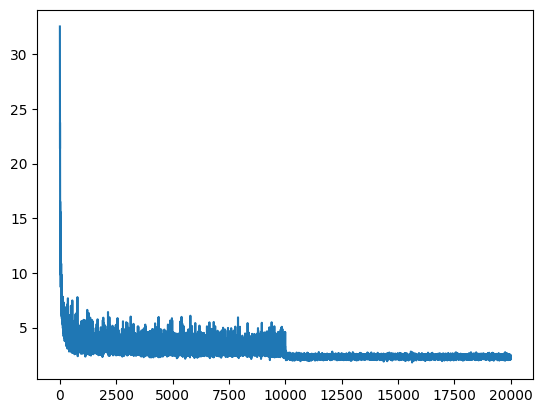

In [74]:
a = 0.01 # from plotting loss against different a and taking minimum

for e in range(epochs):
    # minibatch
    sz = 100
    rows = torch.randint(0, X_train.shape[0], (sz, ))
    
    # forward pass
    emb = C[X_train[rows]]
    h = torch.tanh(emb.view(-1, dim_embed * block_size) @ W1 + b1) # 6 = block_size * dim(embedding space), basically want to get the embedding per input all on one row
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[rows])

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # gradient descent
    #a = lrs[e]
    for p in params:
        p.data -= a * p.grad

    lossi.append(loss.item())
    
plt.plot(lossi)

In [75]:
loss

tensor(2.1731, grad_fn=<NllLossBackward0>)

In [76]:
# computing loss based on dev set


tensor(2.3215, grad_fn=<NllLossBackward0>)

In [77]:
def make_name(k):
    g = torch.Generator().manual_seed(2147483647 + k)
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        i = torch.multinomial(p, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        out.append(i)
        if i == 0:
            break

    return ''.join([itos[i] for i in out])

for k in range(10):
    print(make_name(k))

junide.
kanliino.
xalinn.
haimanna.
hhila.
cari.
arinen.
karyan.
ravva.
keleennt.


In [73]:
if dim_embed == 2:
    plt.figure(figsize=(6,6))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='w')
    plt.grid('minor')